# Tarea 4. Modelos lineales

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://storage.needpix.com/rsynced_images/bayesian-2889576_1280.png" width="200px" height="180px" />

En esta cuarta tarea, tendrás la oportunidad de estimar una relación cúbica usando un modelo lineal Bayesiano. Para esto usarás los datos en `data/Howell1`, considerando personas de todas las edades.

Por favor, intenta ser lo más explícit@ posible, y en lo posible, apóyate de la escritura matemática con $\LaTeX$.

Recuerda además que ante cualquier duda, me puedes contactar al correo esjimenezro@iteso.mx.

<p style="text-align:right;"> Imagen recuperada de: https://storage.needpix.com/rsynced_images/bayesian-2889576_1280.png.</p>

___

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy import stats

In [4]:
%pwd

'/Users/josealmendarez/Documents/Coding'

In [5]:
df = pd.read_csv('data/Howell1.csv')

In [6]:
df.head()

,"height;""weight"";""age"";""male"""
0,151.765;47.8256065;63;1
1,139.7;36.4858065;63;0
2,136.525;31.864838;65;0
3,156.845;53.0419145;41;1
4,145.415;41.276872;51;0


In [7]:
def clean_dataframe(df):
    primera_columna = df.columns[0]
    
    df_clean = df[primera_columna].str.split(';', expand=True)
    
    df_clean.columns = ['height', 'weight', 'age', 'male']
    
    for col in df_clean.columns:
        df_clean[col] = df_clean[col].str.replace('"', '')
    
    df_clean['height'] = df_clean['height'].astype(float)
    df_clean['weight'] = df_clean['weight'].astype(float)
    df_clean['age'] = df_clean['age'].astype(float)  
    df_clean['male'] = df_clean['male'].astype(int)
    
    return df_clean

In [8]:
df_clean = clean_dataframe(df)

In [9]:
df_clean.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [40]:
df_clean.corr()

,height,weight,age,male
height,1.000000,0.940822,0.683689,0.139229
weight,0.940822,1.000000,0.678335,0.155443
age,0.683689,0.678335,1.000000,0.005887
male,0.139229,0.155443,0.005887,1.000000


## 1. 

Describir el modelo usando el lenguaje probabilístico visto en clase. Asegurarse, mediante una simulación predictiva previa que las previas son plausibles.

**Ayuda**. Estandarizar el peso antes.

In [11]:
weight_mean = df_clean['weight'].mean()
weight_std = df_clean['weight'].std()
weight_standardized = (df_clean['weight'] - weight_mean) / weight_std

In [12]:
np.random.seed(42)

def simulate_height(weight_std, N=100):

    alpha = np.random.normal(178, 20, N)
    beta1 = np.random.normal(0, 10, N)
    beta2 = np.random.normal(0, 10, N)
    beta3 = np.random.normal(0, 10, N)
    sigma = np.random.uniform(0, 50, N)
    
    weight_seq = np.linspace(-2, 2, 50)
    predictions = np.zeros((N, len(weight_seq)))
    
    for i in range(N):
        predictions[i] = alpha[i] + beta1[i]*weight_seq + beta2[i]*weight_seq**2 + beta3[i]*weight_seq**3
    
    return weight_seq, predictions

In [13]:
weight_seq, prior_predictions = simulate_height(weight_standardized)

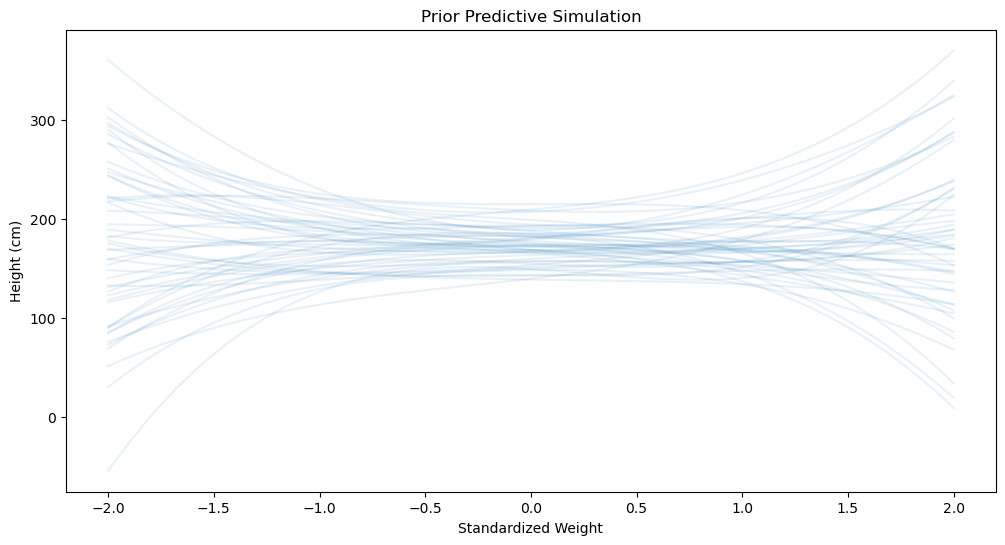

In [14]:
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(weight_seq, prior_predictions[i], 'C0', alpha=0.1)
plt.title('Prior Predictive Simulation')
plt.xlabel('Standardized Weight')
plt.ylabel('Height (cm)')
plt.show()

___
El modelo puede ser descrito jerárquicamente de la siguiente manera:

\begin{align*}
\text{Parámetros del modelo:} \\
\alpha &\sim \mathcal{N}(200, 20^2) \\
\beta_1 &\sim \mathcal{N}(0, 10^2) \\
\beta_2 &\sim \mathcal{N}(0, 10^2) \\
\beta_3 &\sim \mathcal{N}(0, 10^2) \\
\sigma &\sim \text{Uniforme}(0, 50) \\
\\
\text{Modelo de regresión:} \\
\mu_i &= \alpha + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 \\
\\
\text{Verosimilitud:} \\
\text{height}_i &\sim \mathcal{N}(\mu_i, \sigma^2)
\end{align*}
___
$$
x_i : \text{representa el peso estandarizado del individuo } i
$$
$$
\text{height}_i : \text{es la altura observada del individuo } i
$$
$$
\alpha : \text{es el intercepto (altura media esperada cuando el peso es 0 en escala estandarizada)}
$$
$$
\beta_1, \beta_2, \beta_3 : \text{son los coeficientes del polinomio}
$$
$$
\sigma : \text{es la desviación estándar del error}
$$

De tal manera que:

\begin{equation}
\text{height}_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \epsilon_i
\end{equation}


El modelo asume que la relación entre el peso estandarizado y la altura puede ser capturada por un polinomio de tercer grado, permitiendo una relación no lineal entre estas variables. Los parámetros tienen priors informativos, con la media del intercepto centrada en 178 (una altura promedio razonable en centímetros) y los coeficientes del polinomio centrados en 0 con una varianza moderada.
___



In [16]:
with pm.Model() as model:
    
    alpha = pm.Normal('alpha', mu=200, sigma=20)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    mu = alpha + beta1*weight_standardized + beta2*weight_standardized**2 + beta3*weight_standardized**3
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df_clean['height'])
    
    trace = pm.sample(2000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## 2.

Encontrar la distribución posterior de los parámetros. ¿Qué puede concluir de cada uno de ellos?

In [18]:
results = az.summary(trace, round_to=3, kind='stats', hdi_prob=0.94)

In [19]:
results

,mean,sd,hdi_3%,hdi_97%
alpha,146.733,0.309,146.106,147.292
beta1,15.048,0.487,14.149,15.981
beta2,-6.539,0.261,-7.043,-6.066
beta3,3.580,0.235,3.145,4.029
sigma,4.851,0.150,4.567,5.124


___
Análisis de los parámetros del modelo
___
+ α (α = 146.733):

Representa la altura base (en cm) cuando el peso está en su valor medio (peso estandarizado = 0).
El intervalo de credibilidad del 94% [146.106, 147.292] es bastante estrecho, lo que indica una estimación precisa.
La desviación estándar es pequeña (0.309), lo que sugiere alta certeza en esta estimación.

+ β₁ (β₁ = 15.048):

Este coeficiente corresponde al término lineal y nos dice cuánto cambia la altura por cada unidad de cambio en el peso estandarizado.
Es positivo y bastante grande, lo que confirma que existe una relación positiva fuerte entre el peso y la altura.
El HDI [14.149, 15.981] no incluye el cero, lo que refuerza la idea de que el efecto es positivo.

+ β₂ (β₂ = -6.539):

Este es el coeficiente del término cuadrático.
El valor negativo sugiere una curvatura cóncava hacia abajo, lo que implica que la relación entre peso y altura no es lineal de manera simple, sino que se "aplana" a medida que el peso aumenta.
El HDI [-7.043, -6.066] nos dice que este efecto no lineal es consistente y negativo.

+ β₃ (β₃ = 3.580):

Este es el coeficiente del término cúbico.
Al ser positivo, indica que hay un ajuste adicional a la curvatura en la relación entre peso y altura.
El HDI [3.145, 4.029] sugiere que este efecto cúbico es consistente y robusto.

+ σ (σ = 4.851):

Representa la variabilidad residual del modelo, o sea, la dispersión de las observaciones alrededor de la línea de regresión.
El intervalo de credibilidad [4.567, 5.124] indica que la precisión de las predicciones es razonable.
La desviación estándar sugiere una variabilidad aproximada de ±5 cm en las predicciones de altura.
___
_Conclusiones principales_

El modelo captura adecuadamente una relación no lineal entre el peso y la altura.
Los parámetros están bien estimados, ya que los intervalos de credibilidad (HDI) son estrechos, lo que indica precisión.
La relación entre peso y altura es principalmente positiva (β₁ positivo), pero también presenta importantes efectos no lineales (β₂ y β₃).
La precisión del modelo es razonable, con una desviación estándar de aproximadamente 5 cm, lo que implica una variabilidad moderada en las predicciones.
___

array([[<Axes: ylabel='beta1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta2'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta3'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='sigma'>, <Axes: xlabel='beta1'>,
        <Axes: xlabel='beta2'>, <Axes: xlabel='beta3'>]], dtype=object)

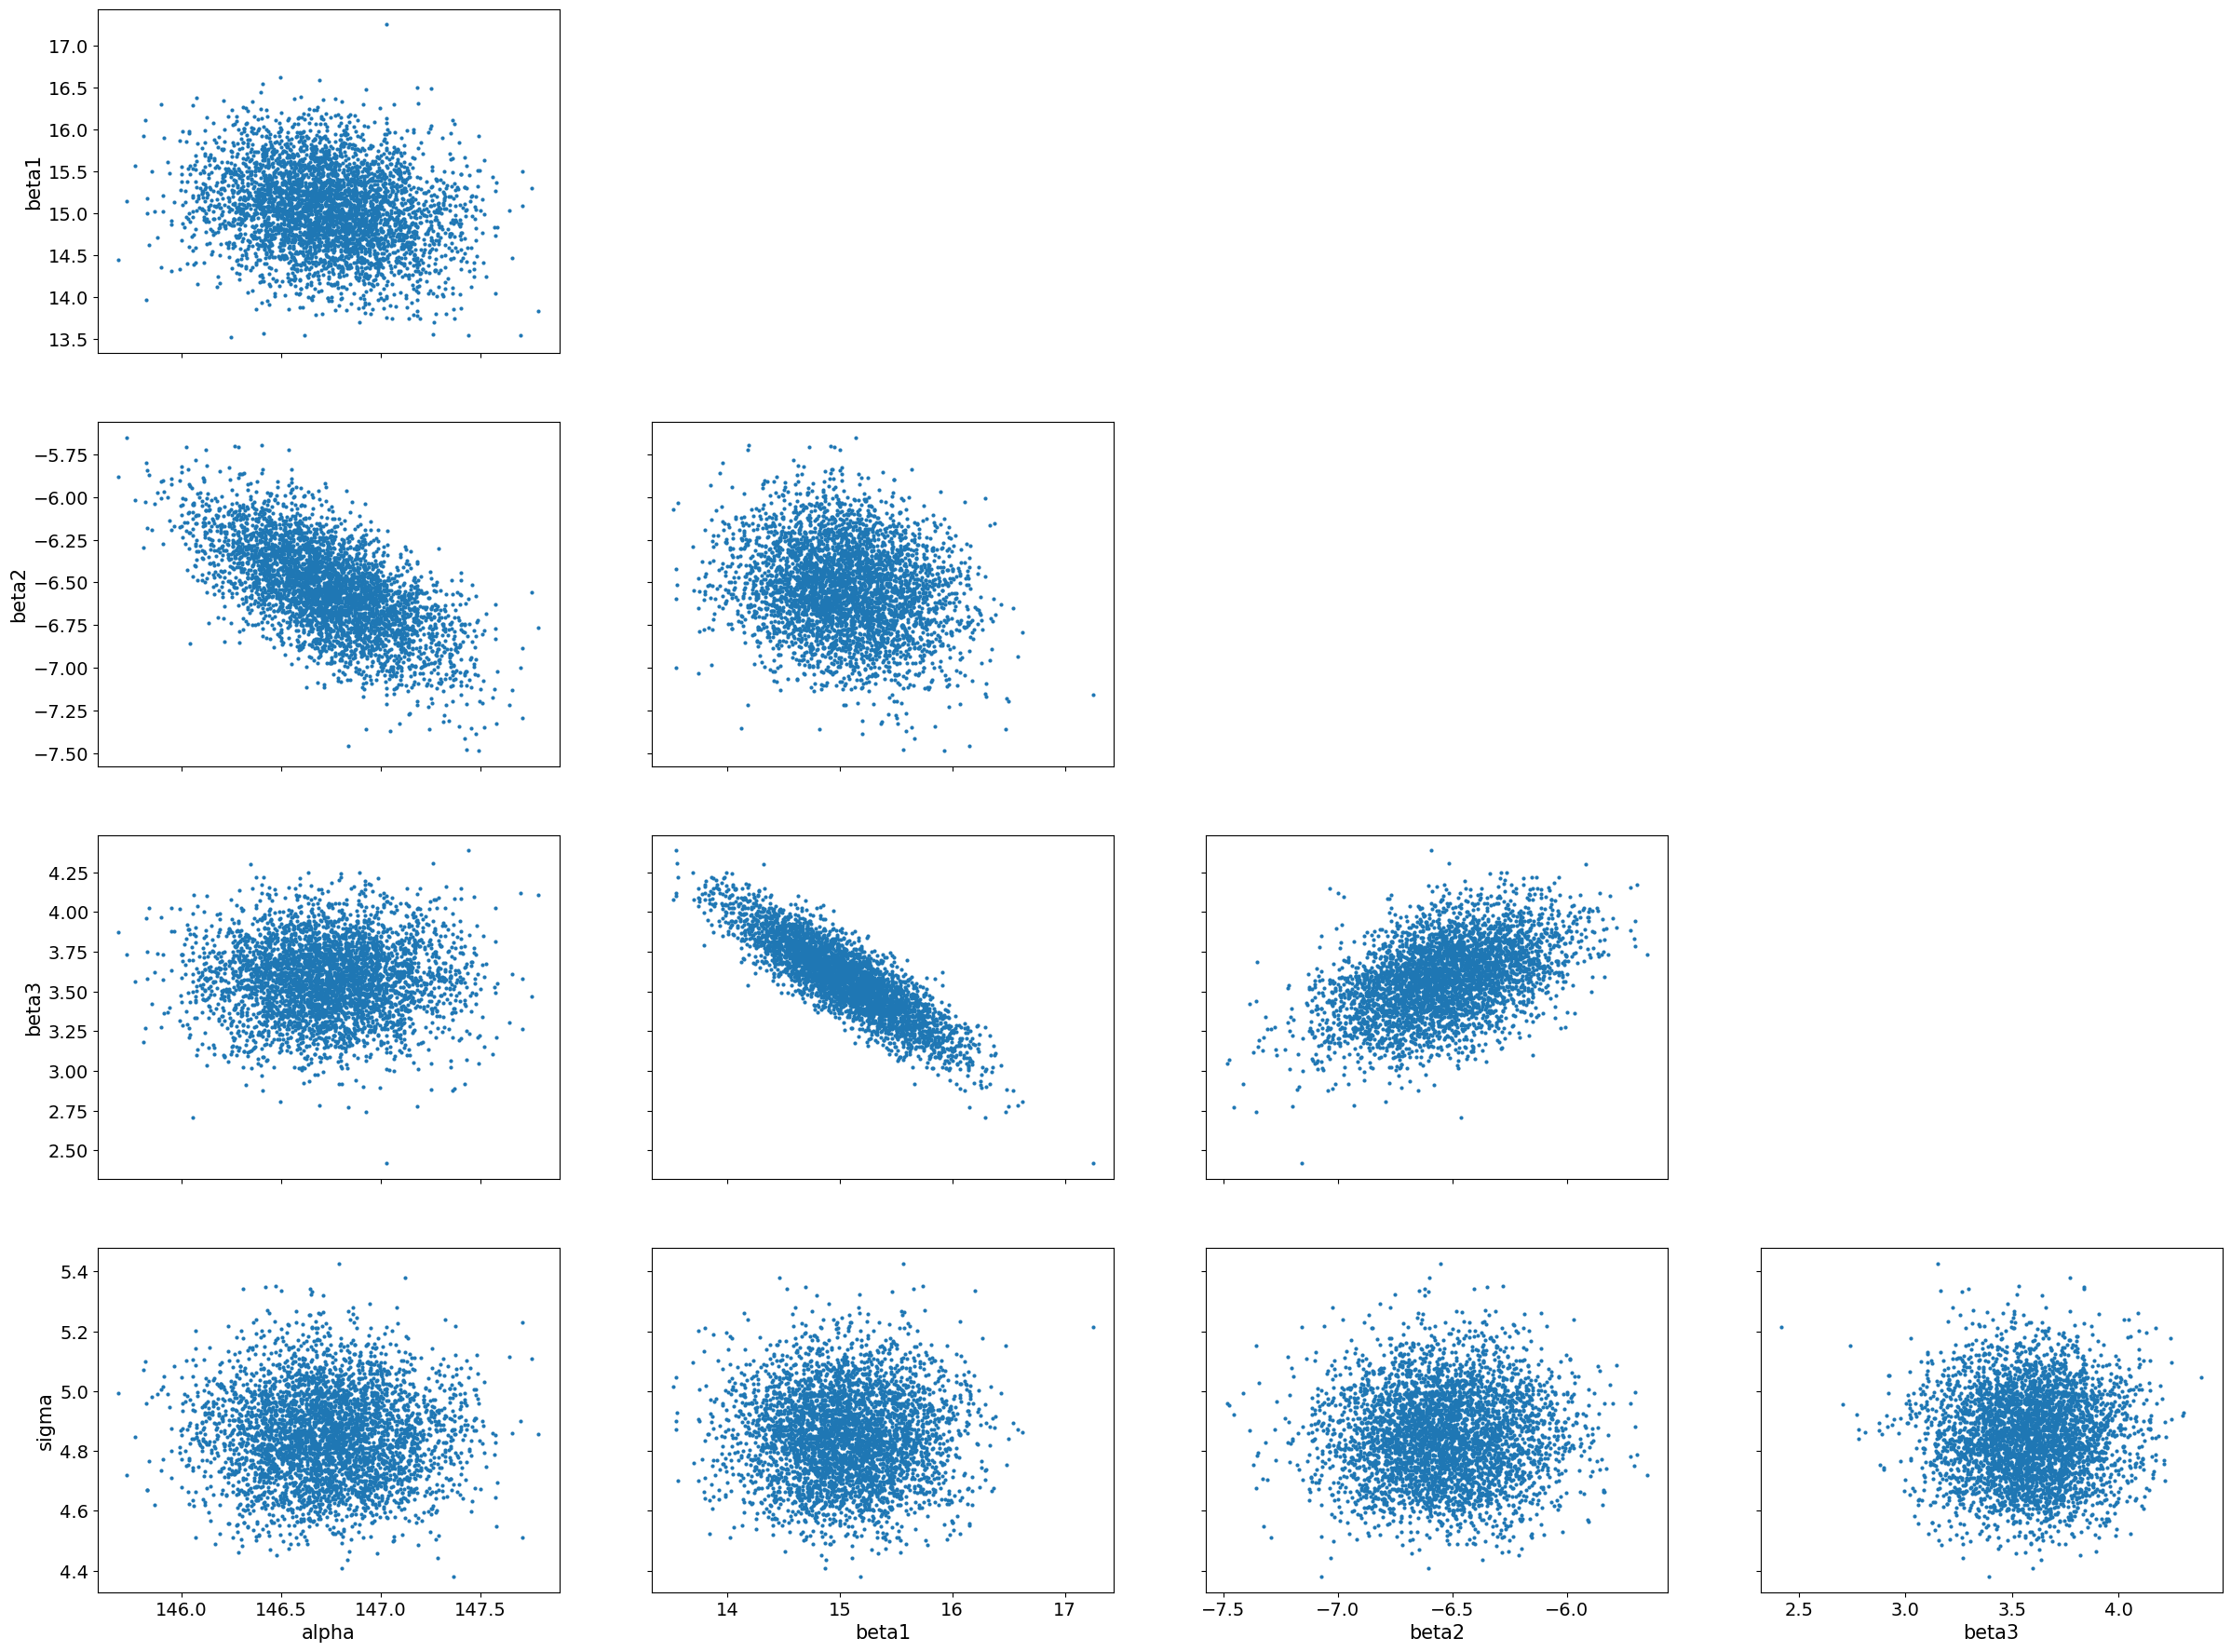

In [21]:
az.plot_pair(trace, var_names=['alpha', 'beta1', 'beta2', 'beta3', 'sigma'])

## 3.

¿Cuál es la distribución de la altura promedio de un infante de 10kg según tu modelo y los datos?

In [25]:
infant_weight = 10
infant_weight_std = (infant_weight - weight_mean) / weight_std

In [23]:
alpha_samples = trace.posterior['alpha'].values.flatten()
beta1_samples = trace.posterior['beta1'].values.flatten()
beta2_samples = trace.posterior['beta2'].values.flatten()
beta3_samples = trace.posterior['beta3'].values.flatten()

In [27]:
predicted_heights = (alpha_samples + 
                    beta1_samples * infant_weight_std +
                    beta2_samples * infant_weight_std**2 +
                    beta3_samples * infant_weight_std**3)

In [29]:
mean_height = np.mean(predicted_heights)
median_height = np.median(predicted_heights)
ci_lower, ci_upper = np.percentile(predicted_heights, [2.5, 97.5])

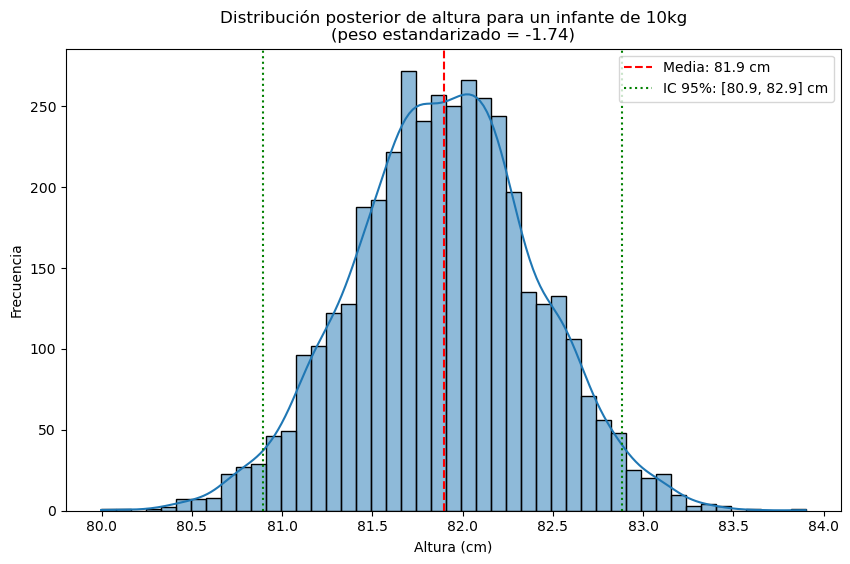

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(predicted_heights, kde=True)
plt.axvline(mean_height, color='red', linestyle='--', label=f'Media: {mean_height:.1f} cm')
plt.axvline(ci_lower, color='green', linestyle=':', label=f'IC 95%: [{ci_lower:.1f}, {ci_upper:.1f}] cm')
plt.axvline(ci_upper, color='green', linestyle=':')
plt.title(f'Distribución posterior de altura para un infante de 10kg\n(peso estandarizado = {infant_weight_std:.2f})')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [33]:
print(f"Para un infante de 10kg:")
print(f"Altura promedio estimada: {mean_height:.1f} cm")
print(f"Altura mediana estimada: {median_height:.1f} cm")
print(f"Intervalo de credibilidad del 95%: [{ci_lower:.1f}, {ci_upper:.1f}] cm")

Para un infante de 10kg:
Altura promedio estimada: 81.9 cm
Altura mediana estimada: 81.9 cm
Intervalo de credibilidad del 95%: [80.9, 82.9] cm


## 4.

Graficar:

- El intervalo de credibilidad al 89% de la altura para cada peso.
- El intervalo de credibilidad al 89% de la altura promedio para cada peso.
- La altura promedio para cada peso.
- Los puntos correspondientes a cada individuo.

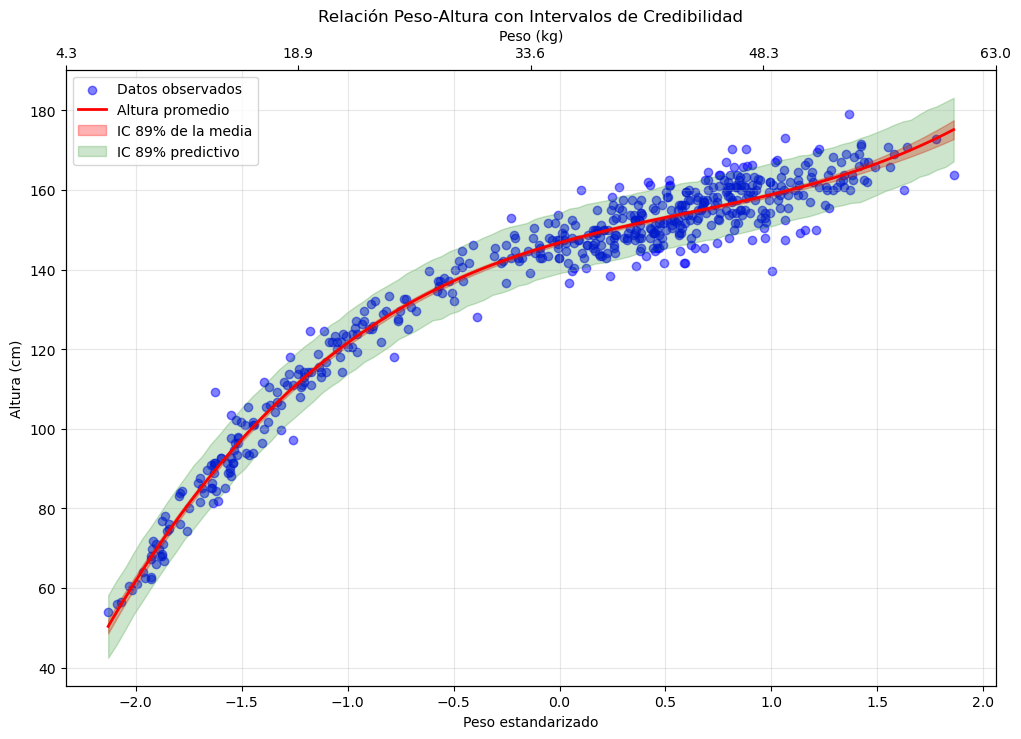

In [35]:
weight_range = np.linspace(weight_standardized.min(), weight_standardized.max(), 100)

alpha_samples = trace.posterior['alpha'].values.flatten()
beta1_samples = trace.posterior['beta1'].values.flatten()
beta2_samples = trace.posterior['beta2'].values.flatten()
beta3_samples = trace.posterior['beta3'].values.flatten()
sigma_samples = trace.posterior['sigma'].values.flatten()

heights_pred = np.zeros((len(alpha_samples), len(weight_range)))
for i in range(len(alpha_samples)):
    heights_pred[i] = (alpha_samples[i] + 
                      beta1_samples[i] * weight_range +
                      beta2_samples[i] * weight_range**2 +
                      beta3_samples[i] * weight_range**3)

mean_height = np.mean(heights_pred, axis=0)
hdi_89_height = np.percentile(heights_pred, [5.5, 94.5], axis=0)

pred_heights = np.zeros((len(alpha_samples), len(weight_range)))
for i in range(len(alpha_samples)):
    pred_heights[i] = heights_pred[i] + np.random.normal(0, sigma_samples[i], len(weight_range))
hdi_89_pred = np.percentile(pred_heights, [5.5, 94.5], axis=0)

plt.figure(figsize=(12, 8))

plt.scatter(weight_standardized, df_clean['height'], alpha=0.5, label='Datos observados', color='blue')

plt.plot(weight_range, mean_height, 'r-', label='Altura promedio', linewidth=2)

plt.fill_between(weight_range, hdi_89_height[0], hdi_89_height[1], 
                alpha=0.3, color='red', label='IC 89% de la media')

plt.fill_between(weight_range, hdi_89_pred[0], hdi_89_pred[1], 
                alpha=0.2, color='green', label='IC 89% predictivo')

plt.xlabel('Peso estandarizado')
plt.ylabel('Altura (cm)')
plt.title('Relación Peso-Altura con Intervalos de Credibilidad')
plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.gca().twiny()
weight_ticks = np.linspace(weight_standardized.min(), weight_standardized.max(), 5)
weight_labels = [f'{w * weight_std + weight_mean:.1f}' for w in weight_ticks]
ax2.set_xticks(weight_ticks)
ax2.set_xticklabels(weight_labels)
ax2.set_xlabel('Peso (kg)')

plt.show()

La relación no es lineal
+ La incertidumbre (ancho de las bandas) es menor en las zonas con más datos
+ La variabilidad individual (banda verde) es considerablemente mayor que la incertidumbre en la media (banda roja)
+ El modelo parece capturar bien la tendencia general de los datos

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez and completed by the student José Almendarez.
</footer>